# CAPSTONE 3. Predicting Major Cryptocurrencies Prices
## Exploratory Data Analysis
In this notebook we will perform Exploratory Data Analysis. The goal of this notebook is to take a closer look at our data and see if we can extract any insights from it. The questions we would like to answer by the end of this notebook are:<br>
<ul><i>What is the biggest token in terms of total market capitalization?<br>
    What is the biggest token in terms of trading volume?<br>
    What token has the highest price?<br>
    What token shows the highest ROI?<br>
    Is there any intercorrelation between tokens' prices?<br>
    What are the summary statistics for each coin and for all coins combined?<br>
    What features are correlated with each other?<br>
    What is the nature of this correlation?</i><br>
</ul>
This is not a complete list by any means. During our analysis we will come up with some other quiestions and we will answer them right away. <br>
Let's start.

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
from functools import reduce
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.stats import linregress
warnings.filterwarnings('ignore')

#setting default figure size
sns.set(rc={"figure.figsize":(12, 6)})
plt.rcParams['figure.figsize'] = (12, 6)

sns.set_style('whitegrid')

#showing only 2 decimals for floats
pd.options.display.float_format = "{:.3f}".format

In [2]:
df = pd.read_csv('../DW/Data_for_EDA.csv')

### Data Overview

In [3]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [4]:
df.head()

,Date,Coin,Price,Market_Cap,Volume
0,2013-04-28,BTC,135.300,1500517590.000,0.000
1,2013-04-29,BTC,141.960,1575032004.000,0.000
2,2013-04-30,BTC,135.300,1501657493.000,0.000
3,2013-05-01,BTC,117.000,1298951550.000,0.000
4,2013-05-02,BTC,103.430,1148667722.000,0.000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6590 entries, 0 to 6589
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        6590 non-null   object 
 1   Coin        6590 non-null   object 
 2   Price       6590 non-null   float64
 3   Market_Cap  6590 non-null   float64
 4   Volume      6590 non-null   float64
dtypes: float64(3), object(2)
memory usage: 257.5+ KB


As we know from the Data Wrangling step, we don't have any missing values, out dates are Datetime objects and the numbers are floats. Now, let's see the period our data spans for and take a look at the summary statistics for each of the tokens.

In [6]:
print(df['Date'].min())
print(df['Date'].max())

2013-04-28
2021-07-24


The earliest observation we have was made on April 28, 2013. The latest one was made on July 24, 2021. Now let's take a look at the summary statistics.

In [7]:
df.describe()

,Price,Market_Cap,Volume
count,6590.000,6590.000,6590.000
mean,3274.453,72588156245.676,7569756823.577
std,8404.921,157861694777.735,14824209579.520
min,0.040,0.000,0.000
25%,28.490,3061403345.016,60792034.218
50%,308.827,13187959289.715,744440194.488
75%,1844.480,70068050620.150,7119796424.973
max,63576.676,1187737045885.174,178894068361.353


We can see from the statistics above that 'total_volume' and 'market_cap' are quite huge. To make it easier for observing we will add two columns with volume values shown <b>in millions</b> and market_cap values shown <b>in billions</b>

In [8]:
#volume in millions
df['Volume_Mil'] = df['Volume'] / 1000000

#market capitalization in billions
df['Market_Cap_Bil'] = df['Market_Cap'] / 1000000000

In [9]:
df.head(3)

,Date,Coin,Price,Market_Cap,Volume,Volume_Mil,Market_Cap_Bil
0,2013-04-28,BTC,135.300,1500517590.000,0.000,0.000,1.501
1,2013-04-29,BTC,141.960,1575032004.000,0.000,0.000,1.575
2,2013-04-30,BTC,135.300,1501657493.000,0.000,0.000,1.502


In [10]:
col = df.pop("Market_Cap_Bil")
df.insert(4, col.name, col)

In [11]:
df = df.sort_values(by='Date')
df.head()

,Date,Coin,Price,Market_Cap,Market_Cap_Bil,Volume,Volume_Mil
0,2013-04-28,BTC,135.300,1500517590.000,1.501,0.000,0.000
1,2013-04-29,BTC,141.960,1575032004.000,1.575,0.000,0.000
2,2013-04-30,BTC,135.300,1501657493.000,1.502,0.000,0.000
3,2013-05-01,BTC,117.000,1298951550.000,1.299,0.000,0.000
4,2013-05-02,BTC,103.430,1148667722.000,1.149,0.000,0.000


Now we'll take a look at the summary statistics of each coin.<br>
#### NOTE: IT IS IMPORTANT TO MENTION THAT THE DATA WAS AQUIRED FROM ONE PARTICULAR CRYPTO EXCHANGE SO IT MAY VARY FROM OTHER EXCHANGES AND AGGREGATORS. WE WILL PERFROM ANALYSIS BASED ON THE DATA AQUIRED FROM COINGECKO.COM

In [12]:
coins = ['BTC', 'ETH', 'BNB']
btc = df[df['Coin'] == 'BTC']
eth = df[df['Coin'] == 'ETH']
bnb = df[df['Coin'] == 'BNB']

In [13]:
dfs = [btc, eth, bnb]
for daf, coin in zip(dfs, coins):
    print(f'================================ Summary statistics for {coin} ================================')
    print(daf.describe())
    print('')

================================ Summary statistics for BTC ================================
          Price        Market_Cap  Market_Cap_Bil           Volume  Volume_Mil
count  3007.000          3007.000        3007.000         3007.000    3007.000
mean   6862.136  123731083444.544         123.731  10817761706.417   10817.762
std   11438.901  213666094249.009         213.666  18023857867.039   18023.858
min      67.809     771368060.000           0.771            0.000       0.000
25%     432.118    6307451188.750           6.307     73603956.311      73.604
50%    2444.494   40066457532.227          40.066   1637948558.256    1637.949
75%    8645.599  151928682321.364         151.929  18547136695.891   18547.137
max   63576.676 1187737045885.174        1187.737 178894068361.353  178894.068

================================ Summary statistics for ETH ================================
         Price       Market_Cap  Market_Cap_Bil           Volume  Volume_Mil
count 2177.000         21

Great. Now it's much easier to see the trading volume and market capitalization of each token. Now we have all the data needed to proceed and answer our questions from the beginning of the notebook.<br>
First we will find out how coin prices changed in 2020.

In [14]:
startdate = dt.datetime.strptime('2019-12-31', "%Y-%m-%d").date()
enddate = dt.datetime.strptime('2020-12-31', "%Y-%m-%d").date()
mask = (df['Date'] > startdate) & (df['Date'] < enddate)
df_2020 = df[mask]

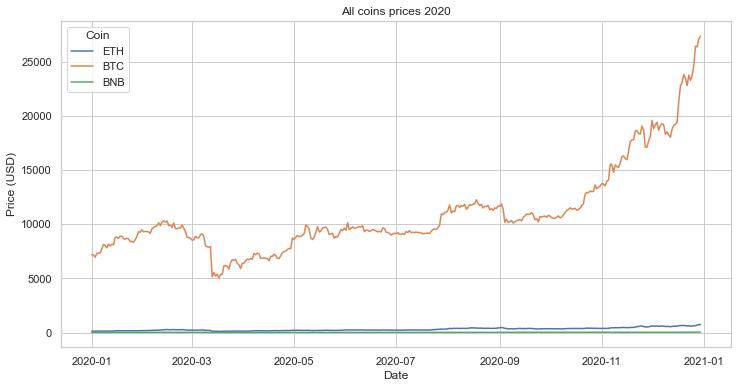

In [15]:
sns.lineplot(data=df_2020, x='Date', y='Price', hue='Coin')
plt.title('All coins prices 2020')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

We can barely see ETH and BNB on the graph, because their prices are very small compared to BTC. Let's take a look at their graphs without BTC.

In [16]:
mask = (df_2020['Coin'] != 'BTC')
df_2020_noBTC = df_2020[mask]

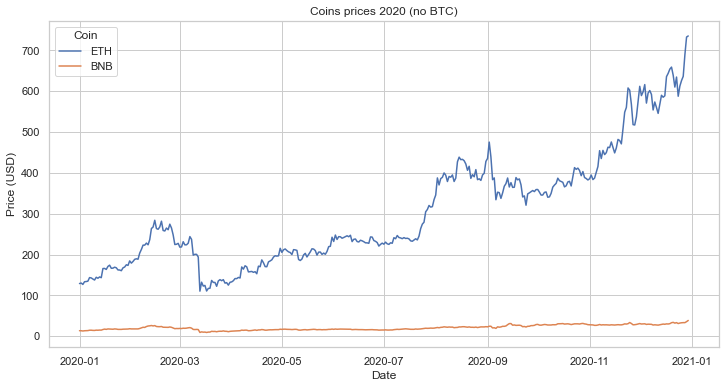

In [17]:
sns.lineplot(data=df_2020_noBTC, x='Date', y='Price', hue='Coin')
plt.title('Coins prices 2020 (no BTC)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

Again, BNB price is shown to be around zero. Let's now take a look at every coin's price on the separate chart.

In [18]:
BTC_2020 = df_2020[df_2020['Coin'] == 'BTC']
ETH_2020 = df_2020[df_2020['Coin'] == 'ETH']
BNB_2020 = df_2020[df_2020['Coin'] == 'BNB']

dfs_2020 = [BTC_2020, ETH_2020, BNB_2020]
colors = ['gold', 'purple', 'orange']

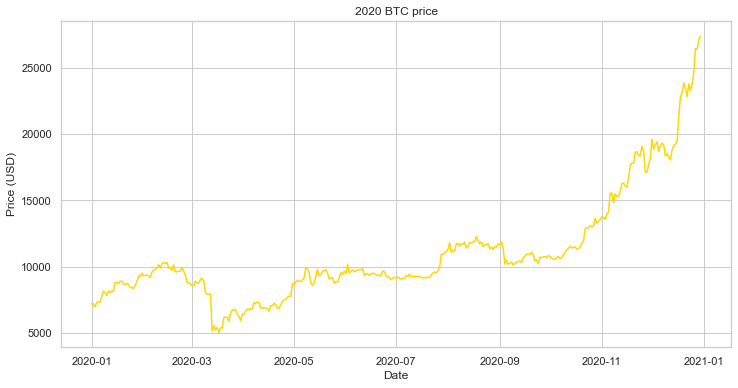

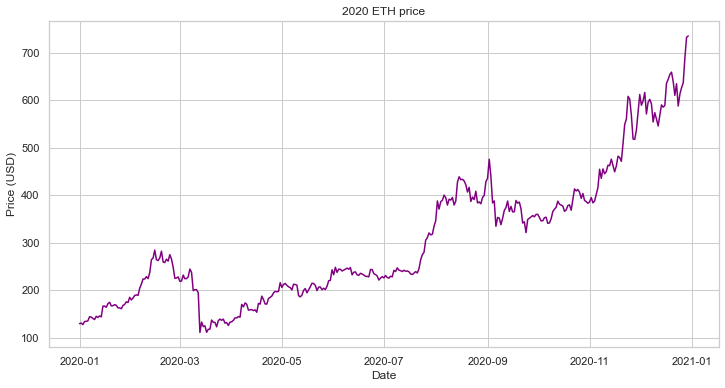

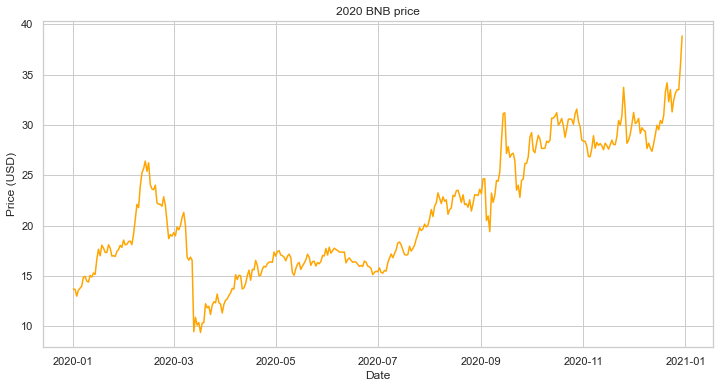

In [19]:
for daf, coin, color in zip(dfs_2020, coins, colors):
    sns.lineplot(data=daf, x='Date', y='Price', color=color)
    plt.title(f'2020 {coin} price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.show();

We see that all coins have very similar patterns and they all started fast growth right after the COVID-19 panic was over in March 2020.<br>
But this is only for 2020. Are they also similar if we look at the broader picture? Let's find out.

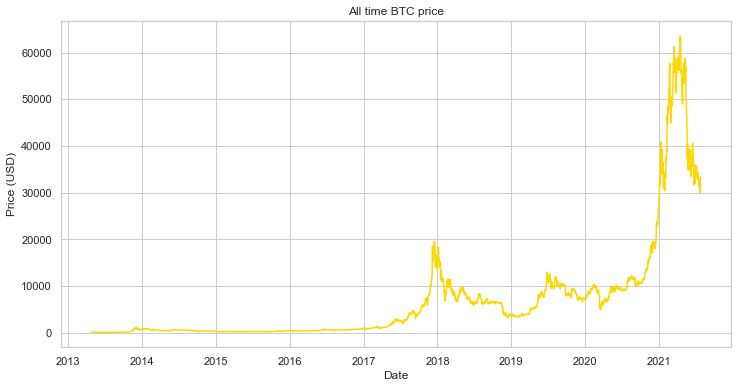

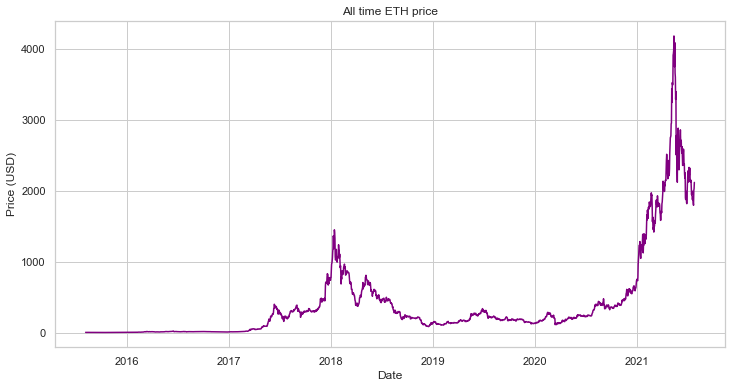

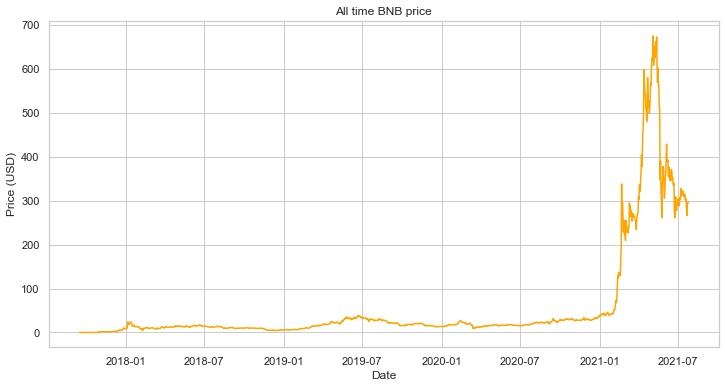

In [20]:
for daf, coin, color in zip(dfs, coins, colors):
    sns.lineplot(data=daf, x='Date', y='Price', color=color)
    plt.title(f'All time {coin} price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.show();

We would like to make some notes here:<br>
1) Bitcoin is the first and biggest cryptocurrency. Historically, all other cryptocurrencies are called "Altcoins". In our example ETH and BNB are altcoins.<br>
2) From the graphs we can tell that all four cryptocurrencies have very similar pattern. They all started to have exponential growth at the end of 2020 and all dropped down at the middle-to-end of the first quarter of 2021

Now we will take a look at the coin's total market cap in 2020.

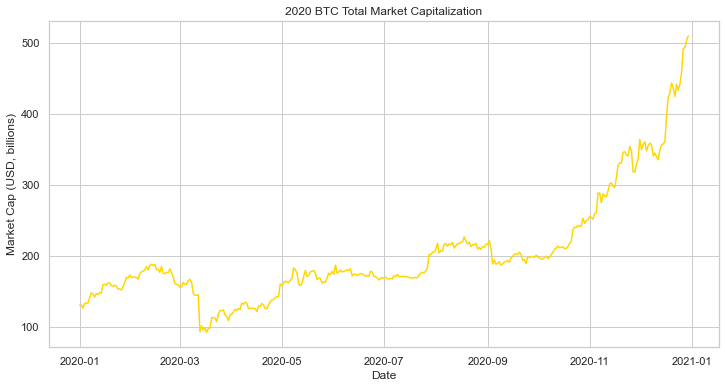

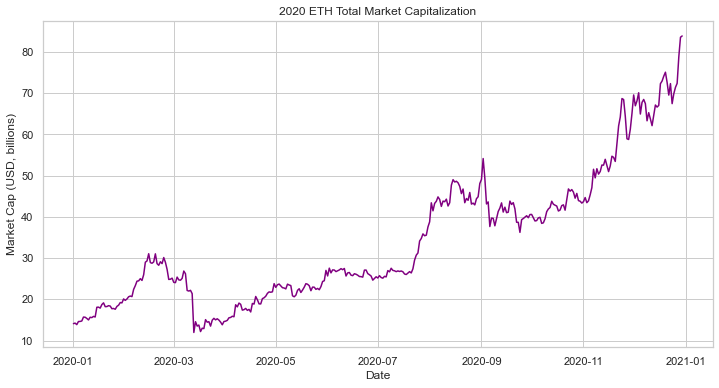

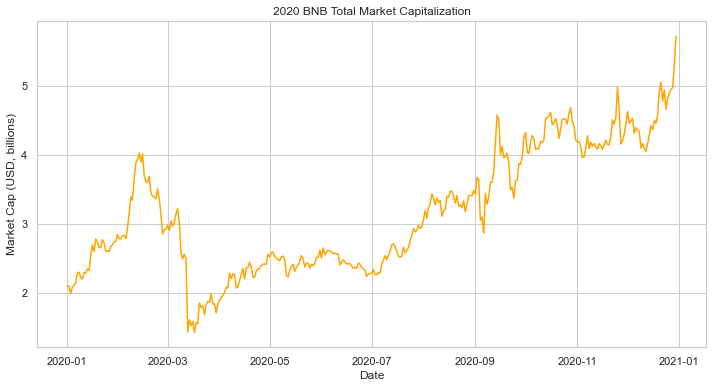

In [21]:
for daf, coin, color in zip(dfs_2020, coins, colors):
    sns.lineplot(data=daf, x='Date', y='Market_Cap_Bil', color=color)
    plt.title(f'2020 {coin} Total Market Capitalization')
    plt.xlabel('Date')
    plt.ylabel('Market Cap (USD, billions)')
    plt.show();

Again, all coins look very similar in terms of the pattern. We would probably expect the patterns to be similar for all time period too.

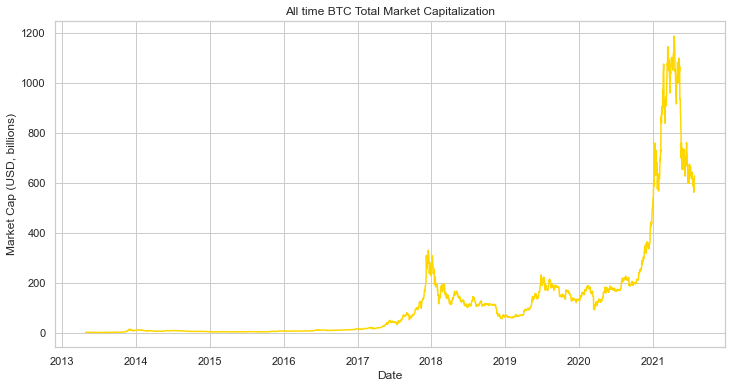

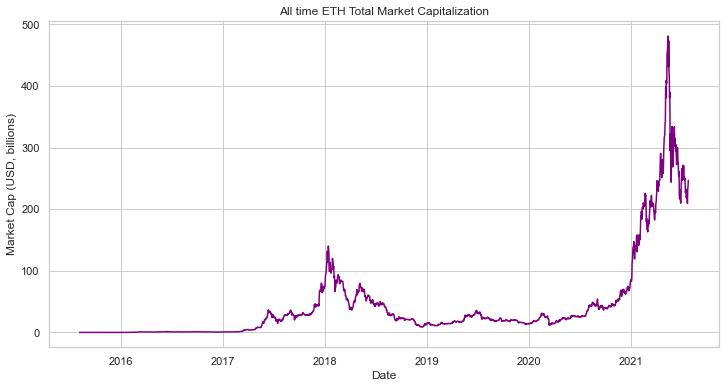

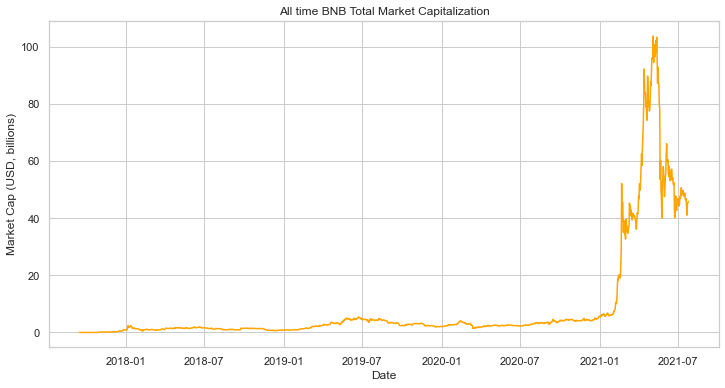

In [22]:
for daf, coin, color in zip(dfs, coins, colors):
    sns.lineplot(data=daf, x='Date', y='Market_Cap_Bil', color=color)
    plt.title(f'All time {coin} Total Market Capitalization')
    plt.xlabel('Date')
    plt.ylabel('Market Cap (USD, billions)')
    plt.show();

Indeed, we see a same pattern. BTC and ETH both had a spike during 2018 bull run, but BNB was a new coin by that time so it didn't really participated in that bull run. All cryptos, however, had exponential growth during the winter 2020/2021 bull run.

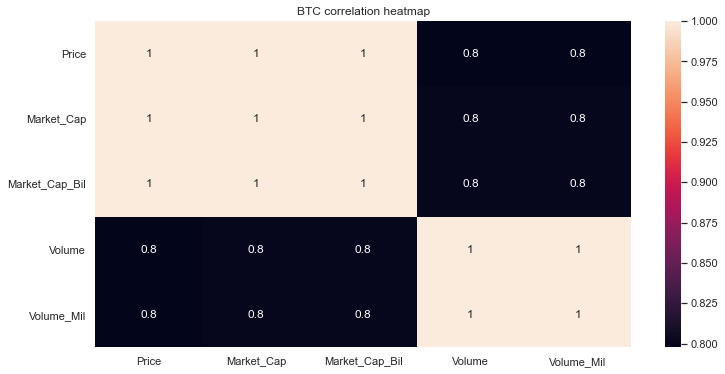

In [23]:
btc_corr = btc.corr()
sns.heatmap(btc_corr, annot=True)
plt.title('BTC correlation heatmap')
plt.show();

'Market_Cap' and 'Volume' features have, of course, perfect correlation with 'Market_Cap_Bil' and 'Volume_Mil' respectively.

In [24]:
btc_for_corr = btc[['Price', 'Volume_Mil', 'Market_Cap_Bil']]
btc_corr = btc_for_corr.corr()

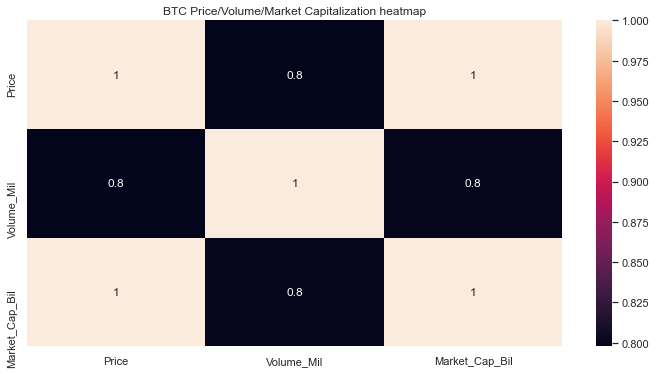

In [25]:
sns.heatmap(btc_corr, annot=True)
plt.title('BTC Price/Volume/Market Capitalization heatmap')
plt.show();

'Price' is strongly correlated with 'Volume_Mil' and perfectly correlated with 'Market_Cap_Bil'. 'Volume_Mil and 'Market_Cap_Bil' are also strongly correlated with each other.

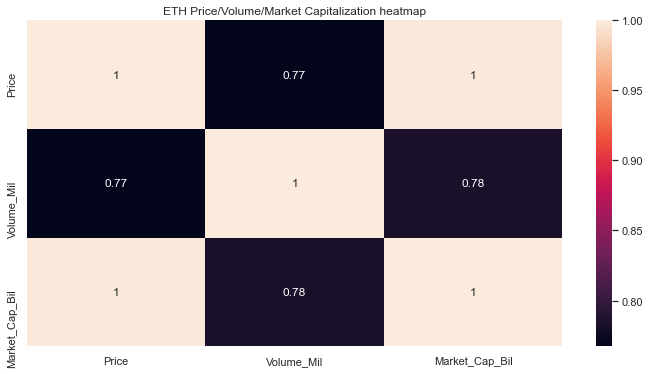

In [26]:
eth_for_corr = eth[['Price', 'Volume_Mil', 'Market_Cap_Bil']]
eth_corr = eth_for_corr.corr()
sns.heatmap(eth_corr, annot=True)
plt.title('ETH Price/Volume/Market Capitalization heatmap')
plt.show();

For ETH we see the same pattern as for BTC.

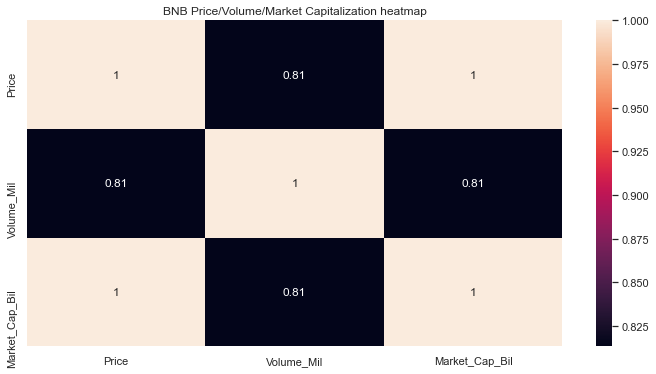

In [27]:
bnb_for_corr = bnb[['Price', 'Volume_Mil', 'Market_Cap_Bil']]
bnb_corr = bnb_for_corr.corr()
sns.heatmap(bnb_corr, annot=True)
plt.title('BNB Price/Volume/Market Capitalization heatmap')
plt.show();

Again, exact same pattern as for BTC and ETH

Now, it would be interesting to see how those features are correlated between different coins.

In [28]:
corr_dfs = [btc_for_corr, eth_for_corr, bnb_for_corr]
date_ser = df['Date']
suffixes = ['_BTC', '_ETH', '_BNB']

In [29]:
for daf in corr_dfs:
    daf.insert(loc=0, column='Date', value=date_ser)

In [30]:
#adding suffixes for better interpretability of the correlation heatmap
for daf, suf in zip(corr_dfs, suffixes):
    daf.columns=daf.columns.map(lambda col : col+suf if col != 'Date' else col)
for daf in corr_dfs:
    print(daf.columns)

Index(['Date', 'Price_BTC', 'Volume_Mil_BTC', 'Market_Cap_Bil_BTC'], dtype='object')
Index(['Date', 'Price_ETH', 'Volume_Mil_ETH', 'Market_Cap_Bil_ETH'], dtype='object')
Index(['Date', 'Price_BNB', 'Volume_Mil_BNB', 'Market_Cap_Bil_BNB'], dtype='object')


In [31]:
#merging correlation dataframes into one
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['Date'], how='outer'), corr_dfs)

In [32]:
df_merged.columns

Index(['Date', 'Price_BTC', 'Volume_Mil_BTC', 'Market_Cap_Bil_BTC',
       'Price_ETH', 'Volume_Mil_ETH', 'Market_Cap_Bil_ETH', 'Price_BNB',
       'Volume_Mil_BNB', 'Market_Cap_Bil_BNB'],
      dtype='object')

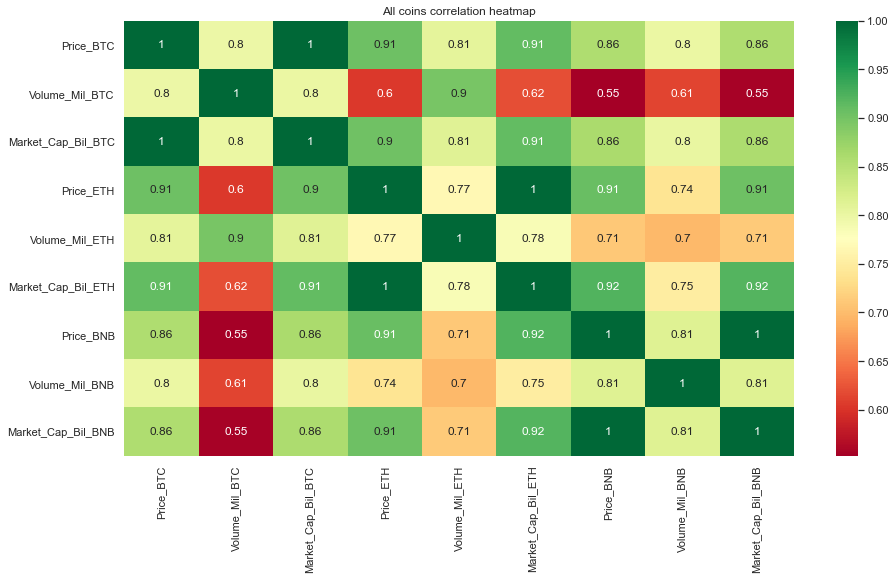

In [33]:
#correlation heatmap for different coins
df_merged_corr = df_merged.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(df_merged_corr, annot=True, cmap='RdYlGn')
plt.title('All coins correlation heatmap')
plt.show();

In [34]:
df_merged_corr

,Price_BTC,Volume_Mil_BTC,Market_Cap_Bil_BTC,Price_ETH,Volume_Mil_ETH,Market_Cap_Bil_ETH,Price_BNB,Volume_Mil_BNB,Market_Cap_Bil_BNB
Price_BTC,1.000,0.798,1.000,0.906,0.807,0.912,0.858,0.799,0.857
Volume_Mil_BTC,0.798,1.000,0.800,0.604,0.898,0.620,0.553,0.612,0.555
Market_Cap_Bil_BTC,1.000,0.800,1.000,0.904,0.812,0.911,0.861,0.801,0.860
Price_ETH,0.906,0.604,0.904,1.000,0.767,0.998,0.908,0.739,0.905
Volume_Mil_ETH,0.807,0.898,0.812,0.767,1.000,0.783,0.712,0.697,0.712
Market_Cap_Bil_ETH,0.912,0.620,0.911,0.998,0.783,1.000,0.922,0.750,0.920
Price_BNB,0.858,0.553,0.861,0.908,0.712,0.922,1.000,0.814,1.000
Volume_Mil_BNB,0.799,0.612,0.801,0.739,0.697,0.750,0.814,1.000,0.813
Market_Cap_Bil_BNB,0.857,0.555,0.860,0.905,0.712,0.920,1.000,0.813,1.000


In [35]:
#looking at the price correlation between different coins
close_cols = [col for col in df_merged.columns if 'Price' in col]
for col in close_cols:
    print('==========', col, '===========')
    print(df_merged_corr[col].sort_values(ascending=False))

========== Price_BTC ===========
Price_BTC            1.000
Market_Cap_Bil_BTC   1.000
Market_Cap_Bil_ETH   0.912
Price_ETH            0.906
Price_BNB            0.858
Market_Cap_Bil_BNB   0.857
Volume_Mil_ETH       0.807
Volume_Mil_BNB       0.799
Volume_Mil_BTC       0.798
Name: Price_BTC, dtype: float64
========== Price_ETH ===========
Price_ETH            1.000
Market_Cap_Bil_ETH   0.998
Price_BNB            0.908
Price_BTC            0.906
Market_Cap_Bil_BNB   0.905
Market_Cap_Bil_BTC   0.904
Volume_Mil_ETH       0.767
Volume_Mil_BNB       0.739
Volume_Mil_BTC       0.604
Name: Price_ETH, dtype: float64
========== Price_BNB ===========
Price_BNB            1.000
Market_Cap_Bil_BNB   1.000
Market_Cap_Bil_ETH   0.922
Price_ETH            0.908
Market_Cap_Bil_BTC   0.861
Price_BTC            0.858
Volume_Mil_BNB       0.814
Volume_Mil_ETH       0.712
Volume_Mil_BTC       0.553
Name: Price_BNB, dtype: float64


As we can see from the heatmap and the list of correlations, all coins' prices are highly correlated with each other. It makes sense, and if we take a look at the price charts we will see that altcoins' prices usually closely follow BTC price with some short time lag. 

### AUTOCORRELATION AND STATIONARITY

#### From here we will focus on BTC price and perform analysis just for this coin. Then we will extend it to other three coins.

<b>Autocorrelation</b> is a type of serial dependence when a time series is linearly related to a lagged version of itself.<br>
Why is it important? A lot of time-series forecasting algorithms are based on regression analysis. One of the assumptions we make before peprforming regression analysis is that the data has no autocorrelation. However, if it actually does, then our analysis will be incorrect and misleading.<br>
<b>Stationarity</b> means that the statistical properties of a process generating a time series do not change over time.<br>
Wht is it important? Stationary processes are possible to predict since the way they change is the same over the period of time. The processes themselves might change, but the way they change is constant, making it easier to model.<br>
<br>
We will now use pandas autocorr method to find out Pearson's correlation coefficient - basically, a normalized measurment of covariance, range from -1(perfect negative correlation) to 1(perfect postivie correlation) - and then plot a corellogram (autocorellation function values) of BTC price and see if the process is stationary.

In [36]:
BTC_price = btc['Price']

In [37]:
print(BTC_price.autocorr())

0.9986630809622649


In [38]:
BTC_price

0        135.300
1        141.960
2        135.300
3        117.000
4        103.430
          ...   
3002   30928.212
3003   29971.904
3004   32383.781
3005   32409.500
3006   33455.551
Name: Price, Length: 3007, dtype: float64

The coefficient of 0.998 clearly shows that BTC price is strongly autocorrelated. Let's plot the ACF now.

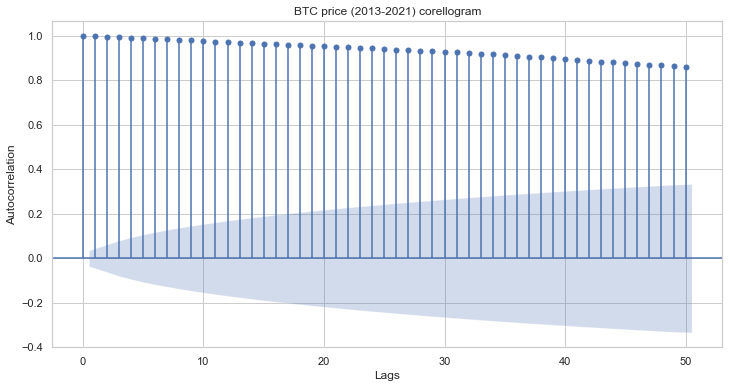

In [39]:
plot_acf(BTC_price, lags=50)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('BTC price (2013-2021) corellogram')
plt.show();

For a stationary process we would expect to see the values of autocorrelation to degrade to zero quickly. However, we don't see it on the plot, and thus we can assume that the process of BTC pricing is not stationary.<br>
Now, let's perform <b>Augmented Dickey-Fuller(ADF)</b> test and make sure that our process is not stationary. The null hypothesis in this test is that a unit root is present in an autoregressive model, and that the process is thus not stationary.<br>
The <b>ADF statistic</b>, used in the test, is a negative number. The <i>more negative</i> it is, the <i>stronger</i> the rejection of the null hypothesis.

In [40]:
result = adfuller(BTC_price)
print('ADF statistic is:', result[0])

ADF statistic is: -0.9014744878526155


We can see that the ADF statistic is -0.9.

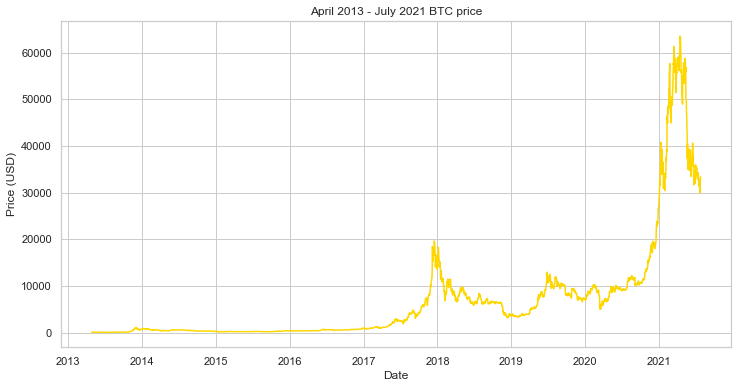

In [41]:
sns.lineplot(data=btc, x='Date', y='Price', color='Gold')
plt.title(f'April 2013 - July 2021 BTC price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

Although we don't necessarily see any seasonality, we can clearly see an upward trend.

### HYPOTHESIS TESTING

For those who are familiar with stock market and know what stock price charts look like, those graphs above should seem very close to what you can see in stock market. We need to introduce an important term here - random walk - because we want to find out if our crypto coins prices are random walks or not.<br> 
<b>Random Walk</b> - mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers.<br>
In other words, we would like to find out if the prices are random or not, because if they are indeed random walks then there is no way we can predict them.<br>

We will now formulate hypothesis - null and alternative.<br>
    <b>Null hypothesis</b> - Non Stationarity exists in the series.<br>
    <b>Alternative hypothesis</b> - Stationarity exists in the series<br>
    In order to find out if our Null hypothesis is correct or not we will perform <b>Augmented Dickey-Fuller Test</b> which is available in statsmodel module for Python. We will not describe the idea of the test here and will just mention that if the p-value will be less than 0.05 then we will be able to reject our Null Hypothesis.

In [42]:
res_norm = adfuller(BTC_price)
print('p-value is:', res_norm[1])

p-value is: 0.7874864598299681


p-value for BTC is 0.7, which is significantly higher than the treshold of 0.05. We <b>fail to reject</b> the null hypothesis. BTC pricing process <b>IS NOT</b> stationary, and we will have to take that into account in our next step - Preprocessing and Training Data Development.

In [43]:
#saving the data
datapath = 'D://Prog/SDST/My Projects/Capstone3/EDA'
if not os.path.exists(datapath):
    os.mkdir(datapath)
datapath_EDA = os.path.join(datapath, 'Data_for_PTDD.csv')
if not os.path.exists(datapath_EDA):
    df.to_csv(datapath_EDA, index=False)
df_merged.to_pickle("./df_merged.pkl")
for df, coin in zip(dfs, coins):
    df.to_pickle(f'./{coin}.pkl')